In [1]:
#Import stuff
import uproot4
import numpy as np
import awkward as ak
from scipy.stats import norm
from scipy.optimize import curve_fit
import os
import copy

import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential, load_model

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

import optparse
import importlib
import pathlib

import hist
from hist import Hist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
plt.style.use(hep.style.ROOT)

# import matplotlib.pylab as pylab
# params = {'legend.fontsize': 'medium',
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'medium',
#          'ytick.labelsize':'medium'}
# pylab.rcParams.update(params)

#line thickness
# import matplotlib as mpl
# mpl.rcParams['lines.linewidth'] = 5


def score_transform_new(iso, pt):
    
    PFTAU_NN_OFFSET = 0.36865313
    PFTAU_NN_SLOPE = 0.00137913
    PFTAU_NN_OVERALL_SCALE = 1./3.

    PFTAU_NN_LOOSE_CUT = 0.05
    PFTAU_NN_TIGHT_CUT = 0.25

    PFTAU_NN_PT_CUTOFF = 200.0
    
    return iso*PFTAU_NN_OVERALL_SCALE*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)
        
# def score_transform(iso, pt):
    
#     PFTAU_NN_OFFSET = 0.1
#     PFTAU_NN_SLOPE = 0.2
#     PFTAU_NN_OVERALL_SCALE = 1. / 20.1

#     PFTAU_NN_LOOSE_CUT = 0.05
#     PFTAU_NN_TIGHT_CUT = 0.25

#     PFTAU_NN_PT_CUTOFF = 100.0
    
#     return iso*(PFTAU_NN_OFFSET + PFTAU_NN_SLOPE*(np.minimum(pt, np.asarray([PFTAU_NN_PT_CUTOFF]))))*PFTAU_NN_OVERALL_SCALE

2023-02-01 07:19:05.271634: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 07:19:05.426337: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Plot efficiency w.r.t tau's pT (testing data)

In [2]:
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
truth_tau_pt = sig['ntuplePupSingle']['tree']['genpt1'].array()[400000:]
reco_tau_pt = sig['ntuplePupSingle']['tree']['pt'].array()[400000:]

#Load model and select out the tau
model = load_model('../models/L1Tau_Jan_25_2023_pTShape_v1.h5')

#Get all the inputs
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[400000:]

pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[400000:]
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[400000:]
eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[400000:]

selection_sig = (pt_sig > 20) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)

#Selected out the tau pt with the basic cuts first
truth_tau_pt_select = truth_tau_pt[selection_sig]
reco_tau_pt_select = reco_tau_pt[selection_sig]

2023-02-01 07:19:09.550968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 07:19:10.774167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:65:00.0, compute capability: 8.0
2023-02-01 07:19:10.775792: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 19727 MB memory:  -> device: 1, name: NVIDIA A30, pci bus id: 0000:ca:00.0, compute capability: 8.0


In [3]:
X_sig = np.asarray(sig_input[selection_sig])
y_sig_model = model.predict(np.nan_to_num(X_sig))

 208/1527 [===>..........................] - ETA: 0s

2023-02-01 07:19:14.756224: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1527/1527 [==============================] - 2s 719us/step


In [4]:
y_sig = score_transform_new(np.asarray(y_sig_model).flatten(), np.asarray(reco_tau_pt_select).flatten())

In [5]:
nn_cut = y_sig.flatten() > 0.05

In [6]:
tau_pt_nn = np.asarray(truth_tau_pt_select)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[400000:][selection_sig])
tau_pt_old_nn = truth_tau_pt_select[old_tau_select == 1]

#Fill two plots and divide the two.
pT_egdes = [0,10,15,20,25,30,35,40,45,50,55,60,70,80,100,125,150] #200?
pT_axis = hist.axis.Variable(pT_egdes, name = r"$\tau_h$ $p_T$")

hist_all_tau = Hist(pT_axis)
hist_selected_tau = Hist(pT_axis)
hist_selected_old_tau = Hist(pT_axis)

hist_all_tau.fill(truth_tau_pt_select)
hist_selected_tau.fill(tau_pt_nn)
hist_selected_old_tau.fill(tau_pt_old_nn)

Hist(Variable([0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 100, 125, 150], name='$\\tau_h$ $p_T$'), storage=Double()) # Sum: 43651.0 (44978.0 with flow)

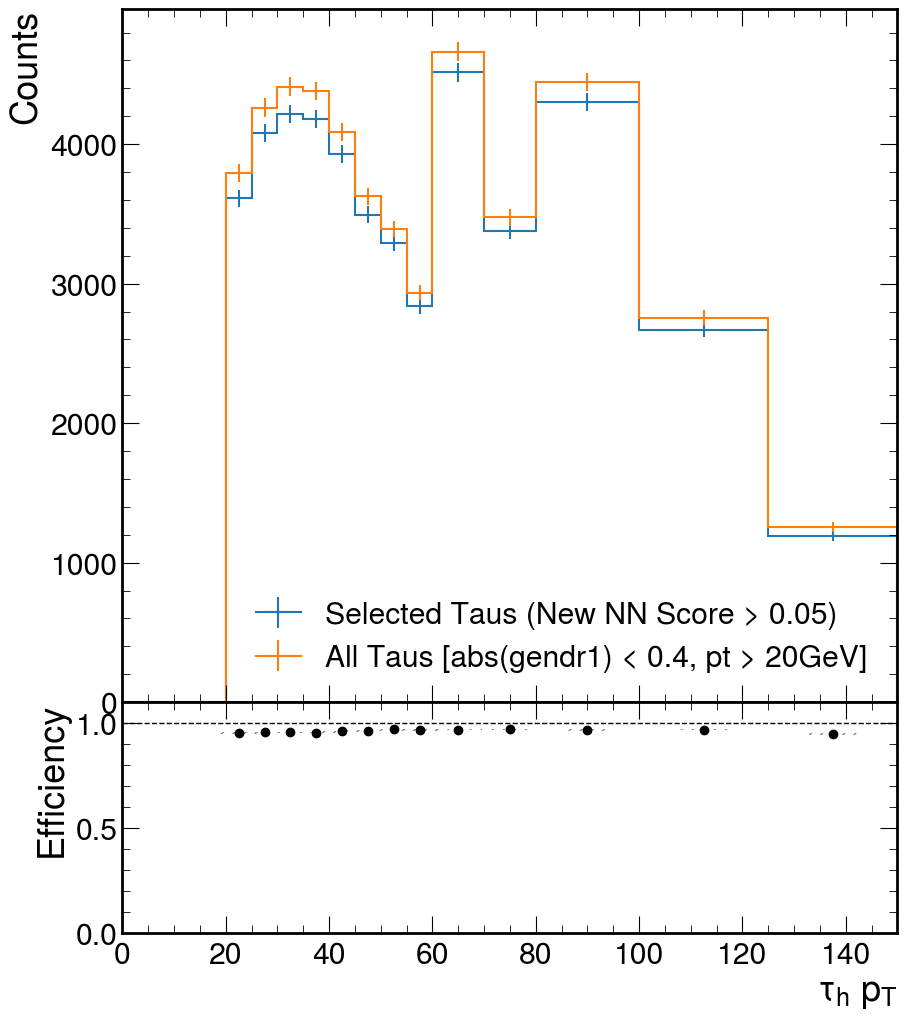

In [7]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (New NN Score > 0.05)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

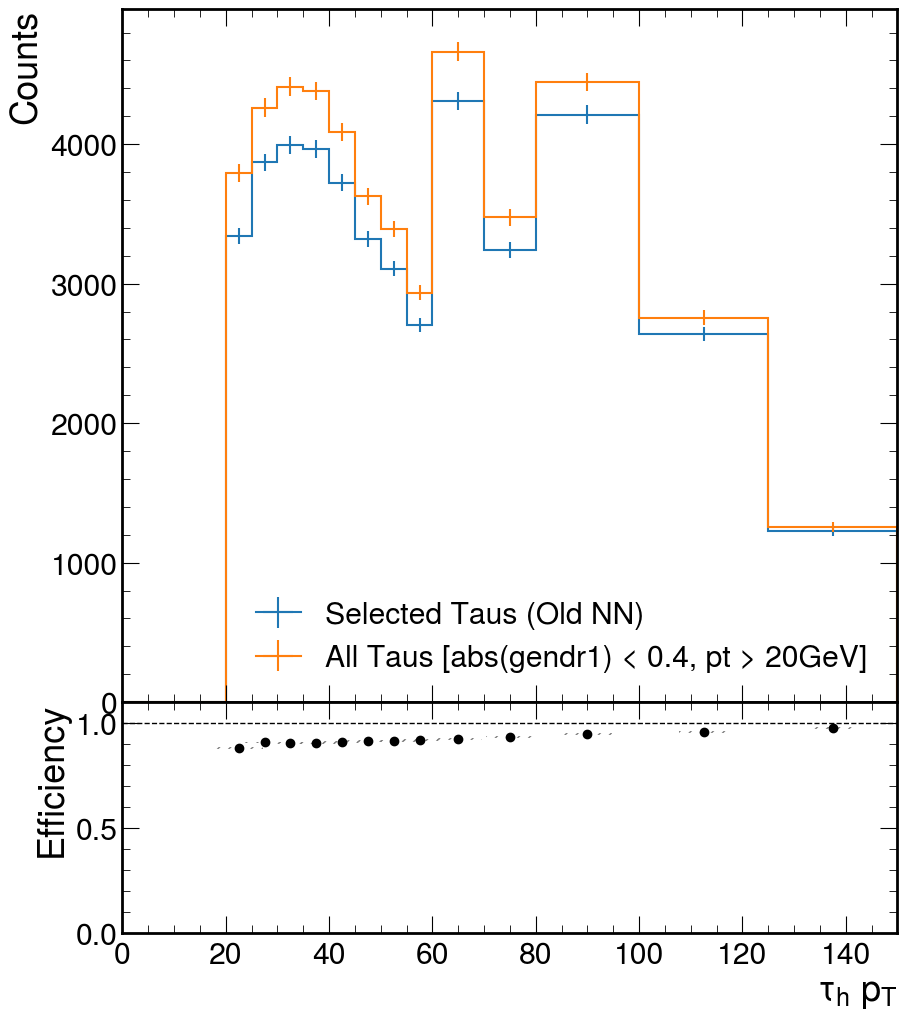

In [8]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (Old NN)",
    rp_denom_label=r"All Taus [abs(gendr1) < 0.4, pt > 20GeV]",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

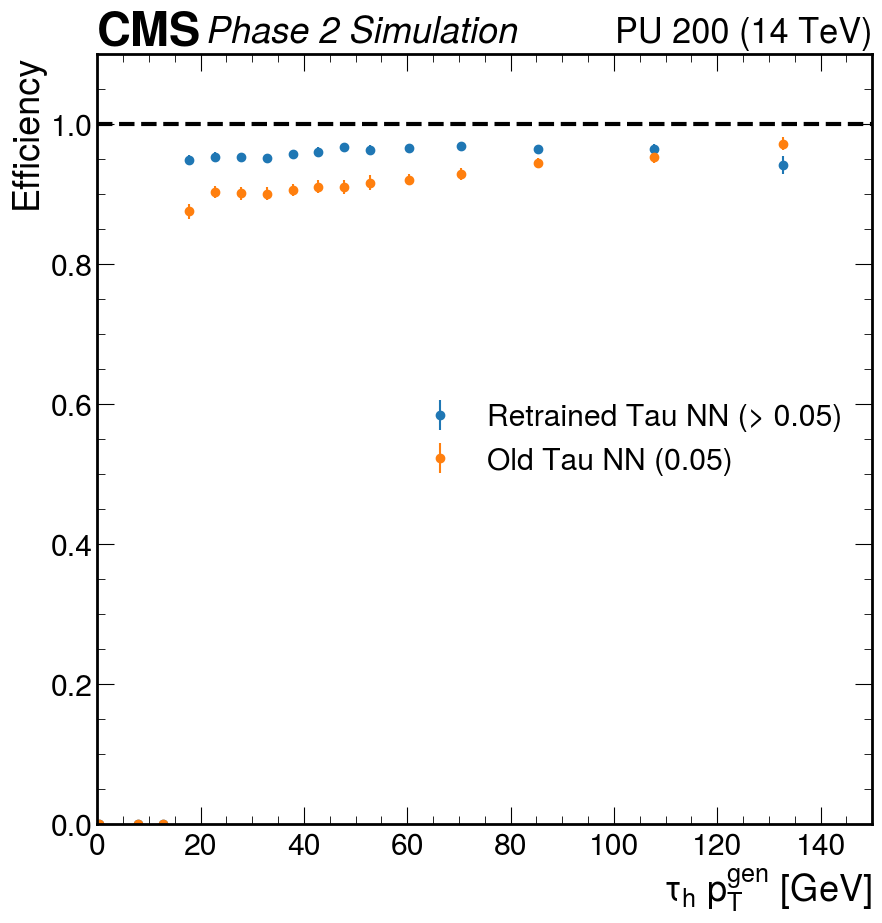

In [9]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN (> 0.05)')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN (0.05)')

plt.hlines(1, 0, 150, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([0,150])
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
plt.xlabel(r"$\tau_h$ $p_T^{gen}$ [GeV]")
plt.ylabel(r"Efficiency")
plt.legend(loc = 'center right')
plt.show()

# Efficiency w.r.t $\eta$ (testing set)
Run this independently from the last part (i.e restart the kernel)

In [10]:
sig = uproot4.open("../ntuples/Jan_25_2023/test_sig_v11.root")
reco_tau_pt = sig['ntuplePupSingle']['tree']['pt'].array()[400000:]
truth_tau_eta = sig['ntuplePupSingle']['tree']['geneta1'].array()[400000:]
reco_tau_eta = sig['ntuplePupSingle']['tree']['eta'].array()[400000:]

#Load model and select out the tau
model = load_model('../models/L1Tau_Jan_25_2023_NormalSample_v2.h5')

#Get all the inputs
sig_input = sig['ntuplePupSingle']['tree']['m_inputs'].array()[400000:]

pt_sig = sig['ntuplePupSingle']['tree']['genpt1'].array()[400000:]
deltaR_sig = sig['ntuplePupSingle']['tree']['gendr1'].array()[400000:]
eta_sig = sig['ntuplePupSingle']['tree']['geneta1'].array()[400000:]

selection_sig = (pt_sig > 20) & (abs(deltaR_sig) < 0.4) & (abs(eta_sig) < 2.4)

#Selected out the tau pt with the basic cuts first
truth_tau_eta_select = truth_tau_eta[selection_sig]
reco_tau_eta_select = reco_tau_eta[selection_sig]
reco_tau_pt_select = reco_tau_pt[selection_sig]

In [11]:
X_sig = np.asarray(sig_input[selection_sig])
y_sig_model = model.predict(np.nan_to_num(X_sig))

1527/1527 [==============================] - 2s 1ms/step


In [12]:
y_sig = score_transform_new(np.asarray(y_sig_model).flatten(), np.asarray(reco_tau_pt_select).flatten())

In [13]:
nn_cut = y_sig.flatten() > 0.05

In [14]:
tau_eta_nn = np.asarray(truth_tau_eta_select)[nn_cut]

#Old nn
old_tau_select = np.asarray(sig['ntuplePupSingle']['tree']['passLoose'].array()[400000:][selection_sig])
tau_eta_old_nn = truth_tau_eta_select[old_tau_select == 1]

#Fill two plots and divide the two.
eta_egdes = [-2.5,-2.3,-2.0,-1.8,-1.6,-1.4,-1.0,-0.6,-0.2,0.2,0.6,1.0,1.4,1.6,1.8,2.0,2.3,2.5]
eta_axis = hist.axis.Variable(eta_egdes, name = r"$\tau_h$ $\eta$")

hist_all_tau = Hist(eta_axis)
hist_selected_tau = Hist(eta_axis)
hist_selected_old_tau = Hist(eta_axis)

hist_all_tau.fill(truth_tau_eta_select)
hist_selected_tau.fill(tau_eta_nn)
hist_selected_old_tau.fill(tau_eta_old_nn)

Hist(Variable([-2.5, -2.3, -2, -1.8, -1.6, -1.4, -1, -0.6, -0.2, 0.2, 0.6, 1, 1.4, 1.6, 1.8, 2, 2.3, 2.5], name='$\\tau_h$ $\\eta$'), storage=Double()) # Sum: 44978.0

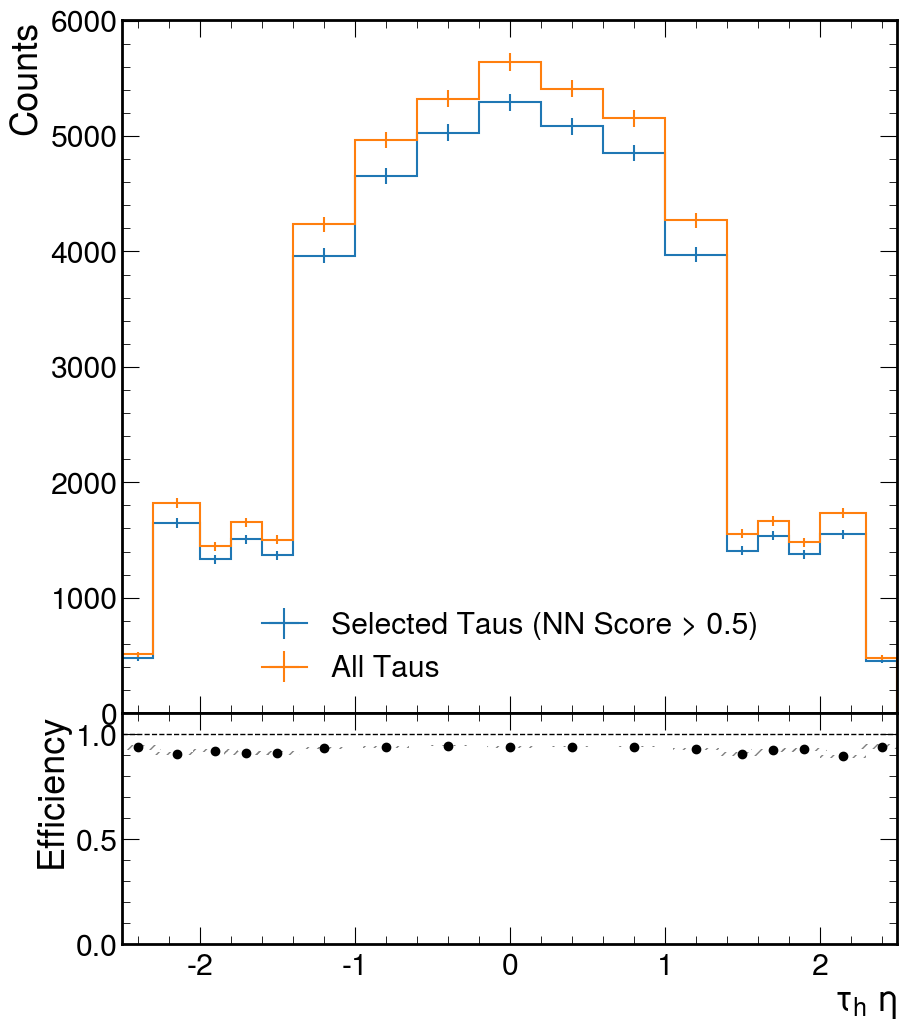

In [15]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_new_nn_artists = hist_selected_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (NN Score > 0.5)",
    rp_denom_label=r"All Taus",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

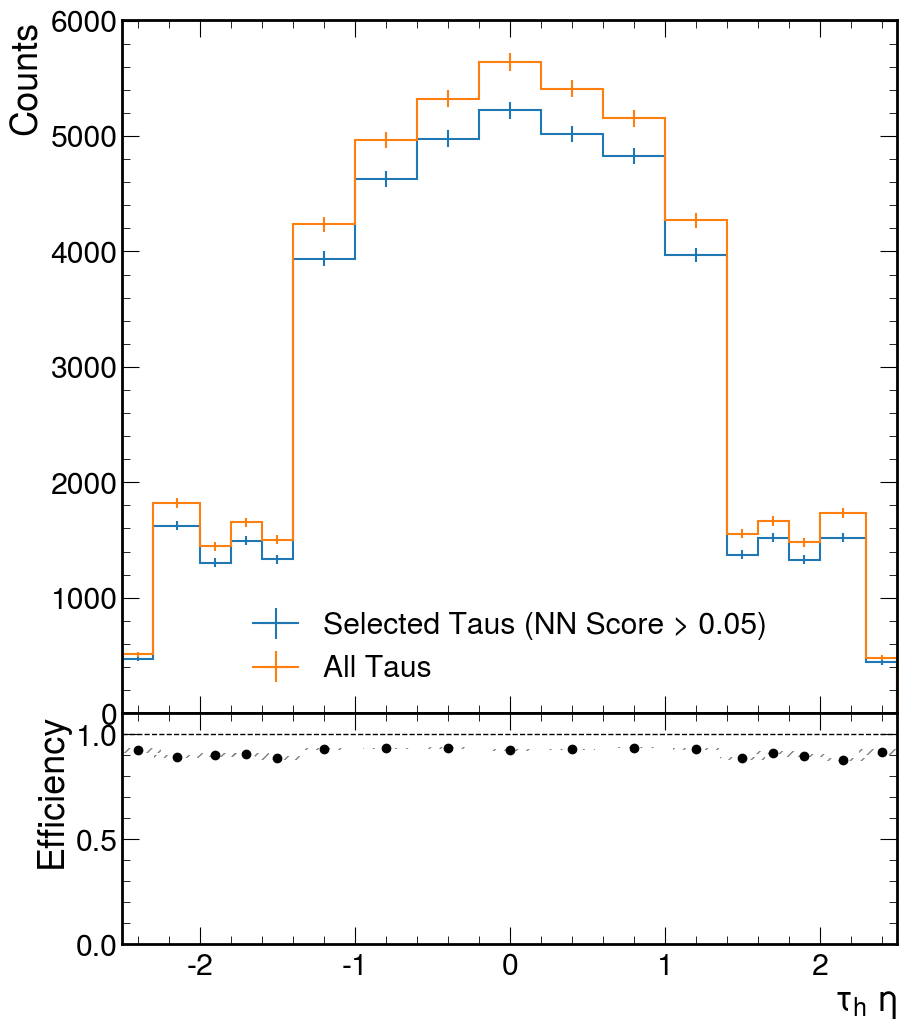

In [16]:
fig = plt.figure(figsize=(10, 12))
main_ax_artists, eff_old_nn_artists = hist_selected_old_tau.plot_ratio(
    hist_all_tau,
    rp_num_label=r"Selected Taus (NN Score > 0.05)",
    rp_denom_label=r"All Taus",
    rp_uncert_draw_type="bar",
    rp_uncertainty_type="efficiency",
)

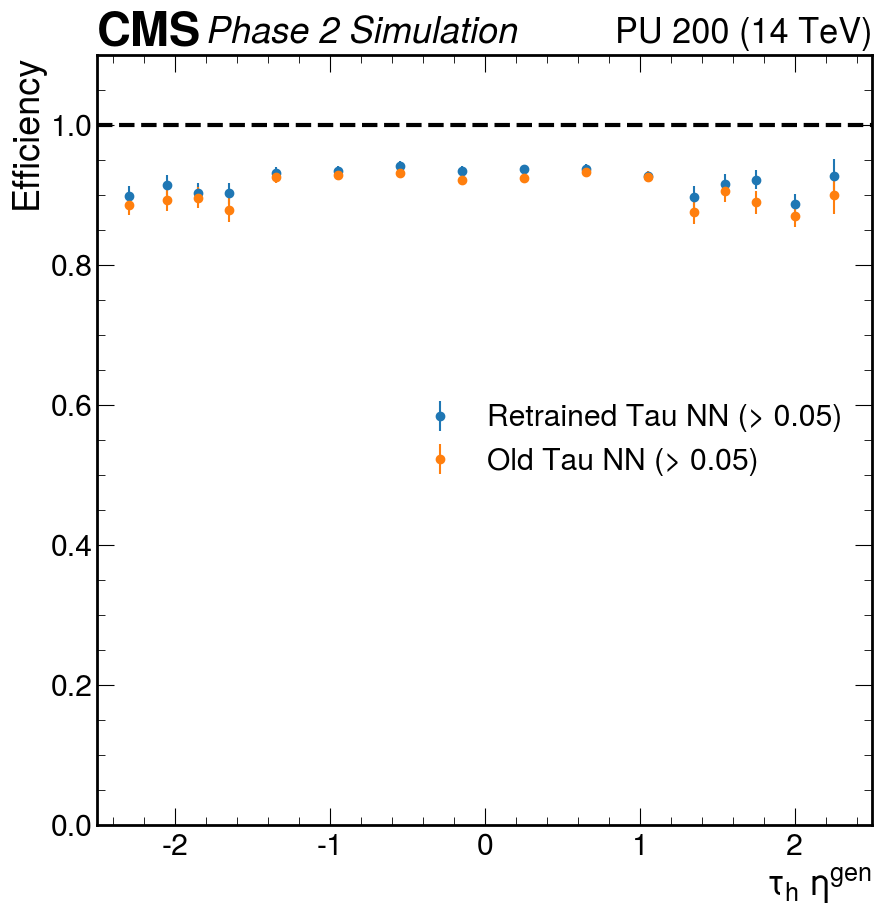

In [17]:
#The real efficiency plot
fig = plt.figure()

eff_new_nn_x = [eff_new_nn_artists.bar.patches[i].get_x() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_y = [eff_new_nn_artists.bar.patches[i].get_y() for i in range(len(eff_new_nn_artists.bar.patches))]
eff_new_nn_err = eff_new_nn_artists.bar.datavalues

eff_old_nn_x = [eff_old_nn_artists.bar.patches[i].get_x() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_y = [eff_old_nn_artists.bar.patches[i].get_y() for i in range(len(eff_old_nn_artists.bar.patches))]
eff_old_nn_err = eff_old_nn_artists.bar.datavalues

plt.errorbar(eff_new_nn_x, eff_new_nn_y, yerr=eff_new_nn_err, fmt='o', label = 'Retrained Tau NN (> 0.05)')
plt.errorbar(eff_old_nn_x, eff_old_nn_y, yerr=eff_old_nn_err, fmt='o', label = 'Old Tau NN (> 0.05)')

plt.hlines(1, -2.5, 2.5, linestyles='dashed', color='black', linewidth=3)
plt.ylim([0,1.1])
plt.xlim([-2.5,2.5])
hep.cms.text("Phase 2 Simulation")
hep.cms.lumitext("PU 200 (14 TeV)")
plt.xlabel(r"$\tau_h$ $\eta^{gen}$")
plt.ylabel("Efficiency")
plt.legend(loc = 'center right')
plt.show()